# Задача: классификация товаров

## Бизнес-контекст

Задача классификации товаров предоставляет бизнесу ценные инструменты для повышения эффективности, лучшего понимания клиентов и более успешного выстраивания стратегий продаж.

Эффективная классификация товаров позволит создать персонализированные рекомендации, подстроенные под потребности конкретного пользователя. Это, в свою очередь, повысит вероятность успешных покупок и улучшит общее взаимодействие с платформой.

Благодаря анализу классификации товаров, бизнес сможет оптимизировать свой ассортимент, выявив наиболее востребованные категории. Также, это предоставит возможность эффективнее управлять партнерскими отношениями, выделяя успешных продавцов в различных категориях товаров.

Такое предприятие не только повысит конверсию, упрощая выбор и покупку для пользователей, но и поднимет конкурентоспособность платформы в глазах клиентов, привлекая новых пользователей и укрепляя позиции на рынке.

## Формальное описание задачи

Разработать сервис классификации продуктов на основе имеющихся данных.

## ML задачи

- провести входной анализ данных (EDA)
- определить метрики для оценки эффективности модели
- сформировть baseline-модель
- предложить улучшенную модель и вывести ее в продакшн

## Описание датасета

Датасет был собран с популярной платформы сравнения продуктов PriceRunner. Он включает в себя 35311 предложений о продуктах из 10 категорий, предоставленных 306 разными продавцами.

Целевые перемнные - номер категории `Category ID` и ее название `Category Label`.

## Ссылка на датасет

[dataset2.zip](./dataset2.zip) (617 KB)

## EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier


In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [3]:
df = pd.read_csv("dataset2.zip")
df.head(10)

,Product ID,Product Title,Merchant ID,Cluster ID,Cluster Label,Category ID,Category Label
0,1,apple iphone 8 plus 64gb silver,1,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
1,2,apple iphone 8 plus 64 gb spacegrau,2,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
3,4,apple iphone 8 plus 64gb space grey,4,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
5,6,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,6,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
6,7,apple iphone 8 plus 64 gb space grey,7,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
7,8,apple iphone 8 plus 64gb space grey,8,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
8,9,apple iphone 8 plus 64gb space grey,9,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
9,10,apple iphone 8 plus 64gb space grey,10,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Product ID       35311 non-null  int64 
 1   Product Title    35311 non-null  object
 2    Merchant ID     35311 non-null  int64 
 3    Cluster ID      35311 non-null  int64 
 4    Cluster Label   35311 non-null  object
 5    Category ID     35311 non-null  int64 
 6    Category Label  35311 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.9+ MB


In [5]:
df.describe()

,Product ID,Merchant ID,Cluster ID,Category ID
count,35311.000000,35311.000000,35311.000000,35311.000000
mean,26150.800176,120.501883,30110.687633,2618.142930
std,13498.191220,117.045557,18410.265642,3.600708
min,1.000000,1.000000,1.000000,2612.000000
25%,14958.500000,17.000000,6123.000000,2615.000000
50%,27614.000000,75.000000,40630.000000,2619.000000
75%,37508.500000,253.000000,44059.000000,2622.000000
max,47358.000000,371.000000,47525.000000,2623.000000


In [6]:
df.duplicated().sum()

0

In [7]:
df.isnull().sum()

Product ID         0
Product Title      0
 Merchant ID       0
 Cluster ID        0
 Cluster Label     0
 Category ID       0
 Category Label    0
dtype: int64

Можно сказать, что исходные данные уже неплохого качеста. Явные дубликаты, пропуски и выборсы отсуствуют.

In [8]:
df.columns = ['product_id', 'product_title', 'merchant_id', 'cluster_id',
              'cluster_label', 'category_id', 'category_label']

In [9]:
df['product_id'].is_unique

True

Поскольку в столбце `product_id` все знчения уникальны, то мы можем заменить индексы на значения данного столбца.

In [10]:
df = df.set_index('product_id')

Посмотрим на распределение объектов в целевом признаке.

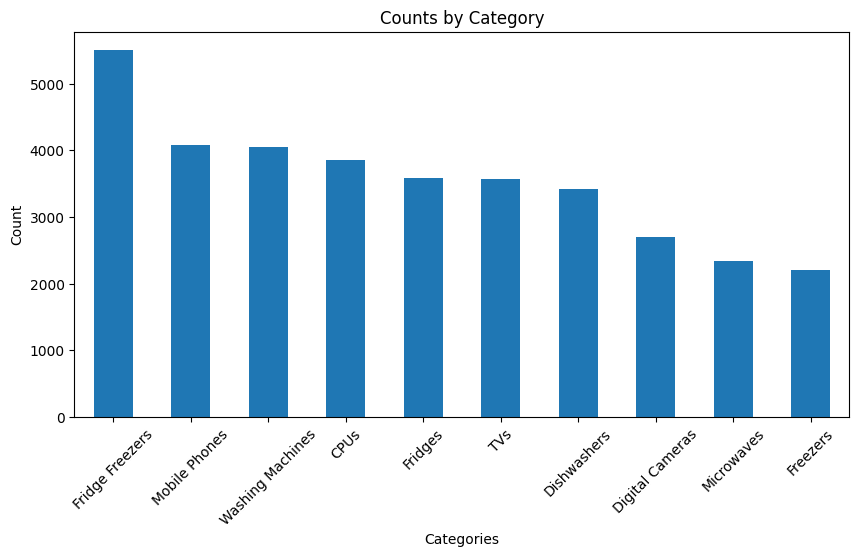

In [11]:
plt.figure(figsize=(10, 5))
df['category_label'].value_counts().plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Counts by Category')
plt.xticks(rotation=45)
plt.show()

В целевом признаке заметен некоторый дисбаланс классов.

In [12]:
df['category_id'].value_counts()

2622    5501
2612    4081
2620    4044
2615    3862
2623    3584
2614    3564
2619    3424
2617    2697
2618    2342
2621    2212
Name: category_id, dtype: int64

In [13]:
df['category_label'].value_counts()

Fridge Freezers     5501
Mobile Phones       4081
Washing Machines    4044
CPUs                3862
Fridges             3584
TVs                 3564
Dishwashers         3424
Digital Cameras     2697
Microwaves          2342
Freezers            2212
Name: category_label, dtype: int64

По всей видимости, столбцы `category_id` и `category_label` содержат одинаковую информацию, нам стоит удалить один из них.

Поскольку в дальнейшем целевой признак мы будем использовать для машнного обучения, то оставим именно его численное представление.

In [14]:
df = df.drop('category_label', axis=1)

Проверим столбцы `cluster_id` и `cluster_label` схожесть.

In [15]:
df['cluster_label'].nunique()

12849

In [16]:
df['cluster_id'].nunique()

13233

В столбцах разное кол-во уникальных элементов, следовательно они различны.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35311 entries, 1 to 47358
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_title  35311 non-null  object
 1   merchant_id    35311 non-null  int64 
 2   cluster_id     35311 non-null  int64 
 3   cluster_label  35311 non-null  object
 4   category_id    35311 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.6+ MB


## Preprocessing

Разобьем данные на выборки.

In [18]:
X = df.drop('category_id', axis=1)
y = df['category_id']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [19]:
print(X_train.shape)
print(X_test.shape)

(26483, 4)
(8828, 4)


Преобразуем категориальные признаки для машинного обучения.

In [20]:
categorical = ['product_title', 'cluster_label']

for category in categorical:
    le = LabelEncoder()
    # Преобразование обучающих данных
    X_train[category] = le.fit_transform(X_train[category])
    # Преобразование тестовых данных с использованием меток обучающих данных
    X_test[category] = X_test[category].map(lambda s: '<unknown>' if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, '<unknown>')
    X_test[category] = le.transform(X_test[category])

X_train.head()

,product_title,merchant_id,cluster_id,cluster_label
product_id,,,,
28481,2197,31,40842,856
21813,21886,3,38913,10484
10059,18562,26,4419,8710
38774,6090,15,44214,2258
25431,18019,53,39959,8472


## Modeling

### Logistic Regression

In [ ]:
model_lr = LogisticRegression(random_state=RANDOM_STATE)
model_lr.fit(X_train, y_train)
predictions_lr = model_lr.predict(X_test)

In [22]:
print(classification_report(y_test, predictions_lr))

              precision    recall  f1-score   support

        2612       0.71      0.99      0.83      1016
        2614       0.65      0.45      0.53       914
        2615       0.32      0.75      0.45       948
        2617       0.04      0.04      0.04       691
        2618       0.00      0.00      0.00       580
        2619       0.00      0.00      0.00       840
        2620       0.00      0.00      0.00       999
        2621       0.00      0.00      0.00       530
        2622       0.36      0.99      0.53      1383
        2623       0.00      0.00      0.00       927

    accuracy                           0.40      8828
   macro avg       0.21      0.32      0.24      8828
weighted avg       0.24      0.40      0.28      8828



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forest

In [23]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE,
                                  n_estimators=8,
                                  max_depth=100)
model_rf.fit(X_train, y_train)
predictions_rf = model_rf.predict(X_test)

In [24]:
print(classification_report(y_test, predictions_rf))

              precision    recall  f1-score   support

        2612       1.00      1.00      1.00      1016
        2614       0.91      1.00      0.95       914
        2615       1.00      0.91      0.95       948
        2617       1.00      1.00      1.00       691
        2618       1.00      1.00      1.00       580
        2619       1.00      0.97      0.99       840
        2620       0.96      1.00      0.98       999
        2621       1.00      0.97      0.98       530
        2622       1.00      1.00      1.00      1383
        2623       1.00      1.00      1.00       927

    accuracy                           0.98      8828
   macro avg       0.99      0.98      0.98      8828
weighted avg       0.99      0.98      0.98      8828



### LightGBM

In [ ]:
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE,
                            n_estimators=8,
                            max_depth=100,
                            learning_rate=0.01)
model_lgbm.fit(X_train, y_train)
predictions_lgbm = model_rf.predict(X_test)

In [30]:
print(classification_report(y_test, predictions_lgbm))

              precision    recall  f1-score   support

        2612       1.00      1.00      1.00      1016
        2614       0.91      1.00      0.95       914
        2615       1.00      0.91      0.95       948
        2617       1.00      1.00      1.00       691
        2618       1.00      1.00      1.00       580
        2619       1.00      0.97      0.99       840
        2620       0.96      1.00      0.98       999
        2621       1.00      0.97      0.98       530
        2622       1.00      1.00      1.00      1383
        2623       1.00      1.00      1.00       927

    accuracy                           0.98      8828
   macro avg       0.99      0.98      0.98      8828
weighted avg       0.99      0.98      0.98      8828



Градиентный бустинг и случайный лес имеют практически одинаковое высокое качество: *accuracy* = **0.98**. Логистрическая регрессия же показала себя хуже: *accuracy* = **0.40**. Веротно, дело в том, что для линейных моделей стоит кодировать признаки с помощью *One Hot Encoding*.

Выгрузим полученные модели

In [31]:
import joblib

joblib.dump(model_rf, 'model_rf.joblib')
joblib.dump(model_lr, 'model_lr.joblib')
joblib.dump(model_lgbm, 'model_lgbm.joblib')

['model_lgbm.joblib']